### Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

### Load & Inspect Dataset

In [3]:
# Load the dataset to a pandas dataframe
df = pd.read_csv('rainfall_data.csv')

In [4]:
df.shape

(366, 12)

In [5]:
df.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pressure       366 non-null    float64
 1   dewpoint       366 non-null    float64
 2   humidity       366 non-null    int64  
 3   cloud          366 non-null    int64  
 4   rainfall       366 non-null    int64  
 5   sunshine       366 non-null    float64
 6   winddirection  366 non-null    float64
 7   windspeed      366 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 23.0 KB


### Data Preprocessing

In [7]:
df.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

In [8]:
# Remove extra spaces in all columns
df.columns = df.columns.str.strip()

In [9]:
df.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [10]:
# Drop day column
df = df.drop(columns=['day'])

In [11]:
df.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [12]:
# Checking the number of missing values
df.isnull().sum()

pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
rainfall         0
sunshine         0
winddirection    1
windspeed        1
dtype: int64

In [13]:
# Handle missing values
df['winddirection'] = df['winddirection'].fillna(df['winddirection'].mode()[0])
df['windspeed'] = df['windspeed'].fillna(df['windspeed'].median())

In [15]:
df.isnull().sum()

pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
rainfall         0
sunshine         0
winddirection    0
windspeed        0
dtype: int64

In [16]:
df['rainfall'].unique()

array(['yes', 'no'], dtype=object)

In [17]:
# Convert the yes & no to 1 & 0 respectively
df['rainfall'] = df['rainfall'].map({'yes': 1, 'no': 0})

In [18]:
df.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,19.9,18.3,16.8,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,21.7,18.9,17.2,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,20.3,19.3,18.0,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,22.3,20.6,19.1,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,21.3,20.7,20.2,19.9,95,81,1,0.0,40.0,13.7


#### Exploratory Data Analysis (EDA)

In [19]:
# Show descriptive statistics of the dataset
df.describe()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1013.742623,26.191257,23.747268,21.894536,19.989071,80.177596,71.128415,0.680328,4.419399,101.284153,21.534153
std,6.414776,5.978343,5.632813,5.594153,5.997021,10.062470,21.798012,0.466988,3.934398,81.722827,10.056054
min,998.500000,7.100000,4.900000,3.100000,-0.400000,36.000000,0.000000,0.000000,0.000000,10.000000,4.400000
25%,1008.500000,21.200000,18.825000,17.125000,16.125000,75.000000,58.000000,0.000000,0.500000,40.000000,13.725000
50%,1013.000000,27.750000,25.450000,23.700000,21.950000,80.500000,80.000000,1.000000,3.500000,70.000000,20.500000
75%,1018.100000,31.200000,28.600000,26.575000,25.000000,87.000000,88.000000,1.000000,8.200000,190.000000,27.825000
max,1034.600000,36.300000,32.400000,30.000000,26.700000,98.000000,100.000000,1.000000,12.100000,350.000000,59.500000


In [20]:
# Setting plot style for all the plots
sns.set_theme(style='whitegrid')

In [21]:
df.columns

Index(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'rainfall', 'sunshine', 'winddirection', 'windspeed'],
      dtype='object')

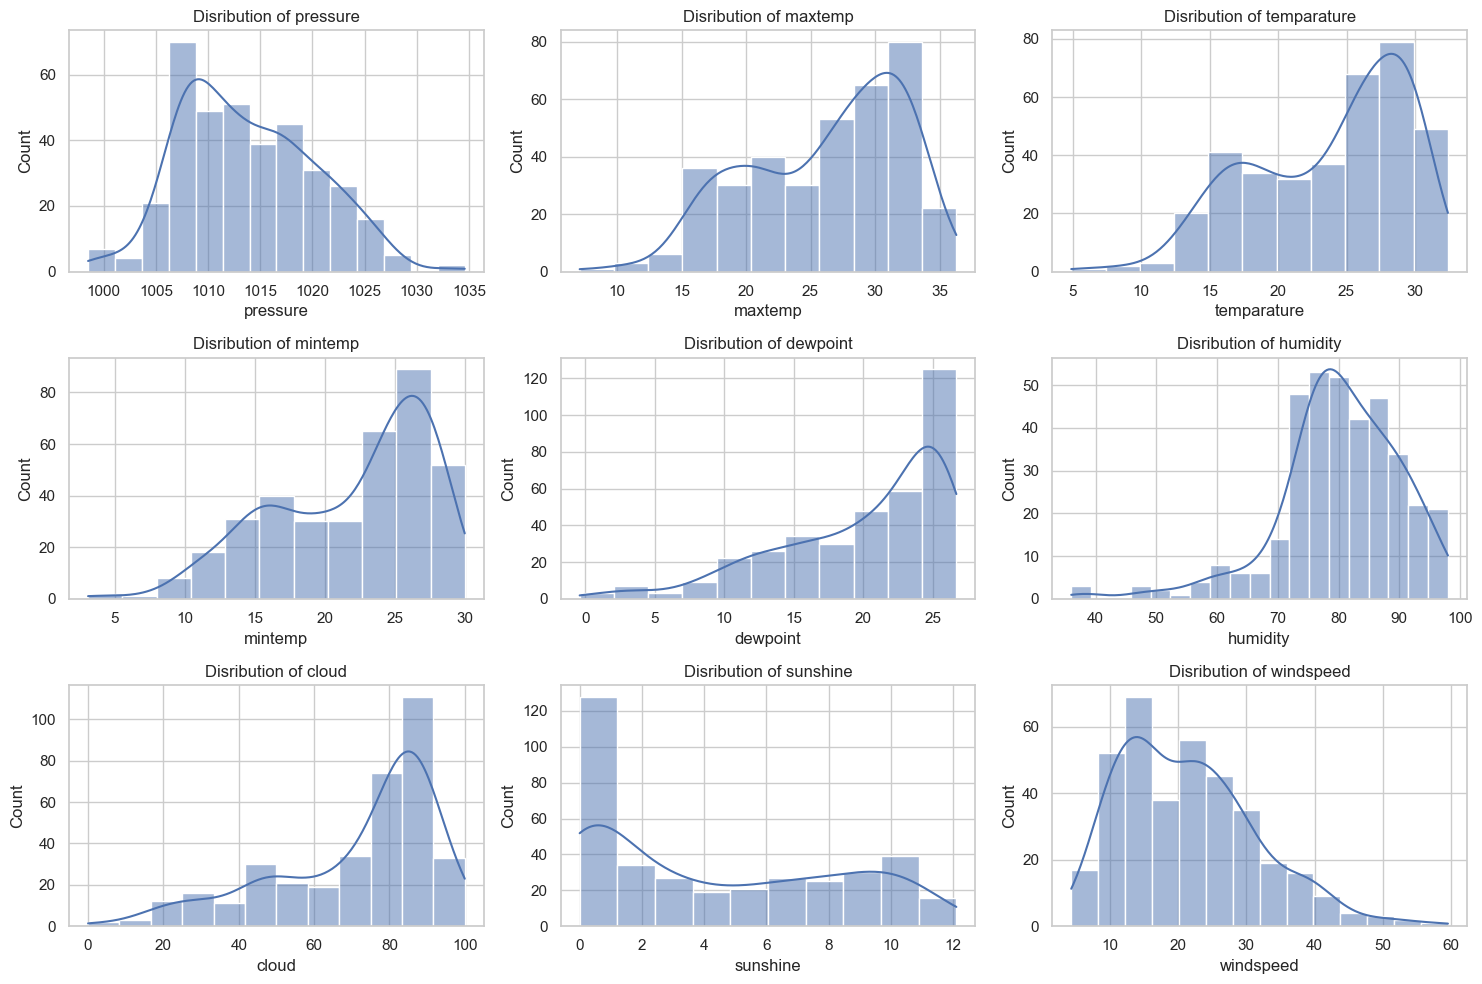

In [22]:
# Plot histogram for selected columns
plt.figure(figsize=(15,10))
for i, column in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed'], 1):
    plt.subplot(3,3,i)
    sns.histplot(df[column], kde=True)
    plt.title(f"Disribution of {column}")

plt.tight_layout()
plt.show()

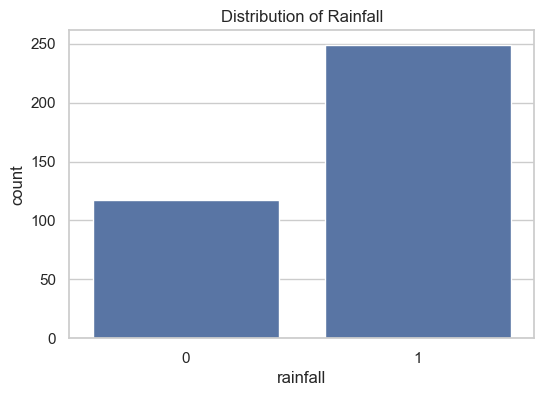

In [23]:
# Plot countplot for the rainfall column
plt.figure(figsize=(6,4))
sns.countplot(x="rainfall", data=df)
plt.title("Distribution of Rainfall")
plt.show()

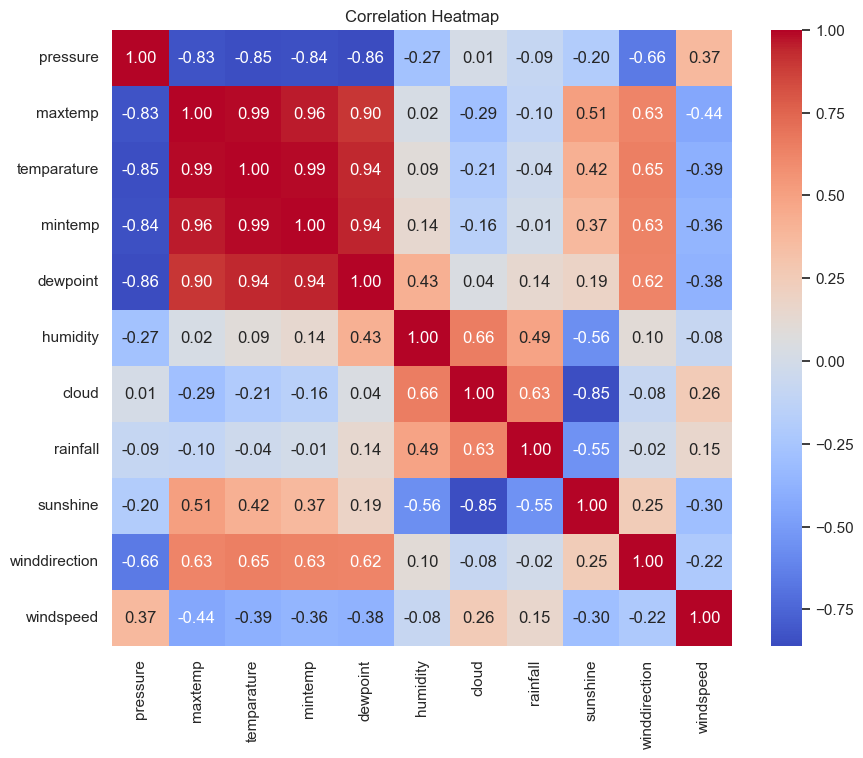

In [24]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

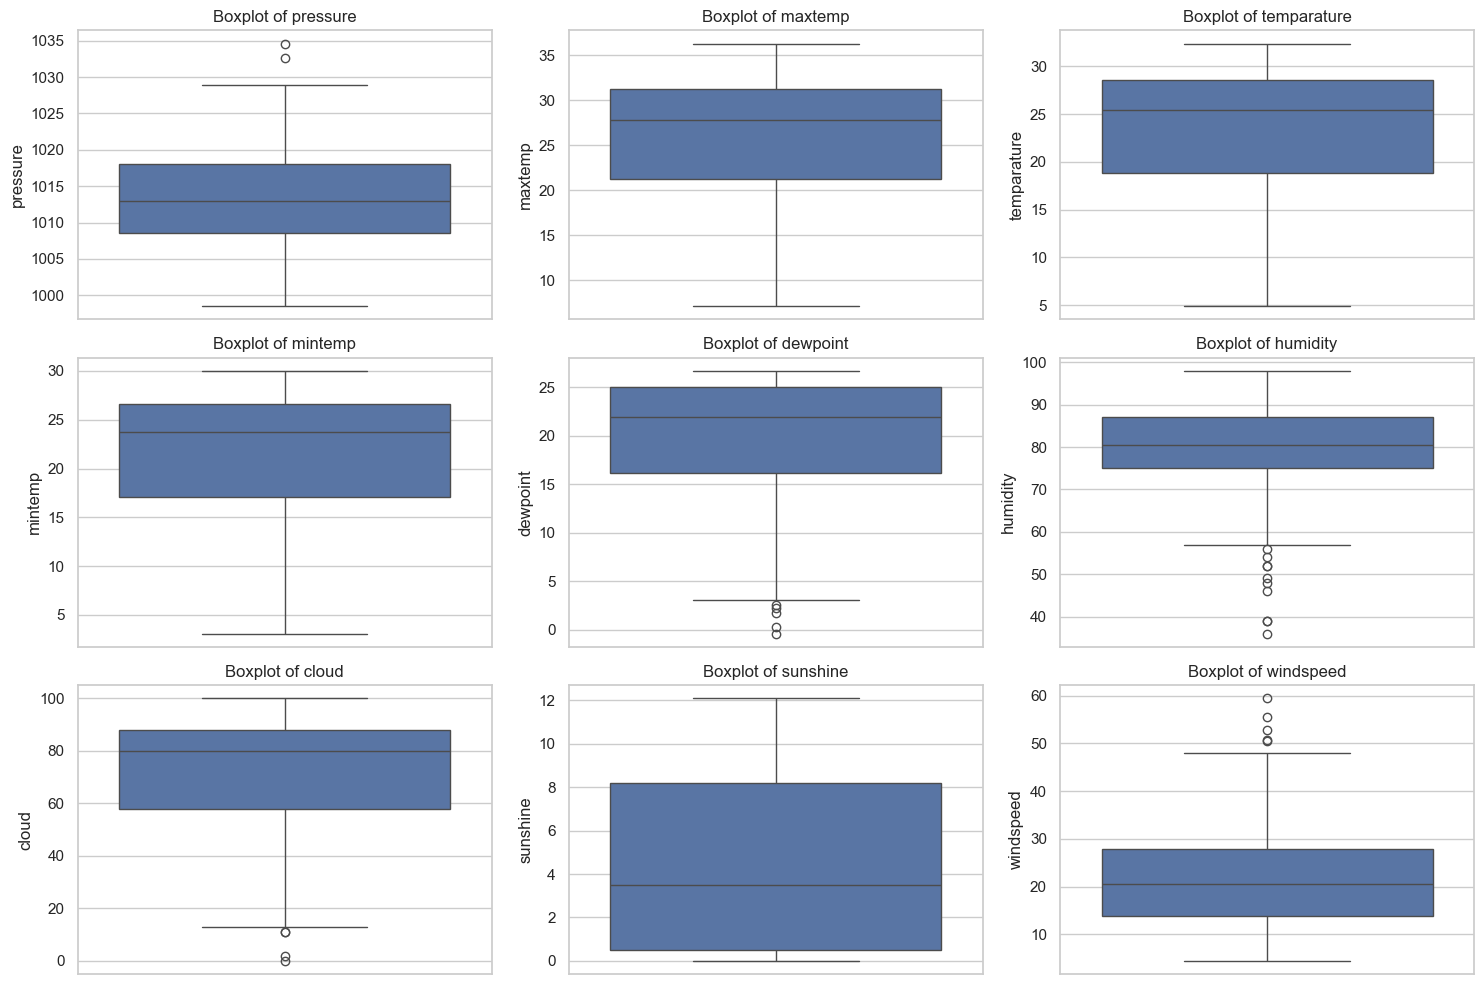

In [25]:
# Plot boxplot for selected columns
plt.figure(figsize=(15,10))
for i, column in enumerate(['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity',
       'cloud', 'sunshine', 'windspeed'], 1):
    plt.subplot(3,3,i)
    sns.boxplot(df[column])
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

#### Additional Data Preprocessing

In [26]:
# Drop highly correlated column
df = df.drop(columns=["maxtemp", "temparature", "mintemp"])

In [27]:
df.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,19.9,95,81,1,0.0,40.0,13.7


In [28]:
df["rainfall"].value_counts()

rainfall
1    249
0    117
Name: count, dtype: int64

In [29]:
# Separate dataset into majority and minority class based on the rainfall column
df_majority = df[df["rainfall"] == 1]
df_minority = df[df["rainfall"] == 0]

In [30]:
print(df_majority.shape)
print(df_minority.shape)

(249, 8)
(117, 8)


In [58]:
# Oversample minority class to match majority class
df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

In [59]:
df_minority_oversampled.shape

(249, 8)

In [60]:
df_oversampled = pd.concat([df_majority, df_minority_oversampled])

In [61]:
df_oversampled.shape

(498, 8)

In [62]:
df_oversampled.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1025.9,13.1,72,49,1,9.3,80.0,26.3
1,1022.0,15.6,81,83,1,0.6,50.0,15.3
2,1019.7,18.4,95,91,1,0.0,40.0,14.2
3,1018.9,18.8,90,88,1,1.0,50.0,16.9
4,1015.9,19.9,95,81,1,0.0,40.0,13.7


In [63]:
# Shuffle the final dataframe
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [64]:
df_oversampled.head()

,pressure,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1010.6,25.1,81,69,0,4.7,170.0,12.1
1,1010.9,24.2,90,86,1,1.1,190.0,16.0
2,1018.4,15.8,85,91,1,0.1,70.0,41.3
3,1007.2,25.9,87,82,1,0.5,250.0,21.3
4,1016.6,17.3,82,84,1,0.4,50.0,20.3


### Feature Engineering

In [65]:
# Split features and target as X and y
X = df_oversampled.drop(columns=["rainfall"])
y = df_oversampled["rainfall"]

In [66]:
X.head()

,pressure,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1010.6,25.1,81,69,4.7,170.0,12.1
1,1010.9,24.2,90,86,1.1,190.0,16.0
2,1018.4,15.8,85,91,0.1,70.0,41.3
3,1007.2,25.9,87,82,0.5,250.0,21.3
4,1016.6,17.3,82,84,0.4,50.0,20.3


In [67]:
y.head()

0    0
1    1
2    1
3    1
4    1
Name: rainfall, dtype: int64

### Data Splitting

In [68]:
# Splitting the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Selection & Training

In [ ]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

### Model Evaluation

In [87]:
y_pred = model.predict(X_test)

In [88]:
y_pred

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [ ]:
score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {score * 100:.2f}%")

print("-"*60)

print("Classification Report")
print(classification_report(y_test, y_pred))

print("-"*60)

Accuracy Score: 86.00%
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        43
           1       0.94      0.81      0.87        57

    accuracy                           0.86       100
   macro avg       0.86      0.87      0.86       100
weighted avg       0.87      0.86      0.86       100

------------------------------------------------------------


### Prediction on unknown Data

In [72]:
input_data = (1015.9, 19.9, 95, 81, 0.0, 40.0, 13.7)

input_df = pd.DataFrame([input_data], columns=['pressure', 'dewpoint', 'humidity', 'cloud', 'sunshine','winddirection', 'windspeed'])

prediction = model.predict(input_df)

In [73]:
prediction

array([1], dtype=int64)

In [74]:
print("Prediction result: ", "Rainfall" if prediction[0] == 1 else "No rainfall")

Prediction result:  Rainfall


### Hyperparameter Tuning

In [75]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\razaq\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [76]:
best_model = grid_search.best_estimator_

print("Best parameters for Random Forest: ", grid_search.best_params_)

Best parameters for Random Forest:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [77]:
# Test the best model
y_pred = best_model.predict(X_test)

In [78]:
y_pred

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [86]:
# Evaluate the performance of the best model
score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {score * 100:.2f}%")

print("-"*60)

print("Classification Report")
print(classification_report(y_test, y_pred))

print("-"*60)

Accuracy Score: 86.00%
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        43
           1       0.94      0.81      0.87        57

    accuracy                           0.86       100
   macro avg       0.86      0.87      0.86       100
weighted avg       0.87      0.86      0.86       100

------------------------------------------------------------


### Save the model

In [80]:
# Save the model and feature names to a pickle file
model_data = {"model": best_model, "feature_names": X.columns.tolist()}

joblib.dump(model_data, "rainfall_prediction_model.pkl")

['rainfall_prediction_model.pkl']

### Tryout the saved model

In [81]:
# Load the saved model and feature names from the pickle file
model_data = joblib.load("rainfall_prediction_model.pkl")

In [82]:
# Extract the model and feature names
model = model_data["model"]
feature_names = model_data["feature_names"]

In [83]:
# Prediction on unknown data
input_data = (1015.9, 19.9, 95, 81, 0.0, 40.0, 13.7)

input_df = pd.DataFrame([input_data], columns=feature_names)

In [84]:
prediction = model.predict(input_df)
print("Prediction result: ", "Rainfall" if prediction[0] == 1 else "No rainfall")

Prediction result:  Rainfall
